<a href="https://colab.research.google.com/github/YashC1308/QSTP-MachineLearning/blob/main/QSTP_NeuralNet_A_2_YC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch import optim, nn                         # These are specific submodules which contain useful functions. optim has optimizers like SGD, Adam
import torch.nn.functional as F                     # nn has several Neural Network related functions
from torch.utils.data import TensorDataset, DataLoader

In [4]:
transform = transforms.ToTensor()
train_dataset = datasets.FashionMNIST(root="./", train=True, transform=transform, download=True)       # Downloads the MNIST dataset into 2 parts: train and test
test_dataset = datasets.FashionMNIST(root="./", train=False, transform=transform, download=True)                      # We train on 60,000 images first, then we test our model on 10,000 unseen images

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)                   # This is like our batch_loader function except it loads 60000/batch_size
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)                    # no. of batches ()

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



torch.Size([1, 28, 28])


9

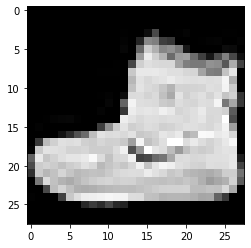

In [5]:
print(train_loader)
train_dataset
image , label = train_dataset[0]
print(image.shape)
plt.imshow(transforms.ToPILImage()(image), cmap="gray")
label

In [6]:
# The neural network we have built earlier is called a feedforward neural network
# All the inputs pass through fully-connected layers (each neuron in one layer is connected to each neuron in the next) and send information only in one direction
# Hence, we have the linear layers called fc1 and fc2 (fully connected layers)

class FeedforwardNeuralNetwork(nn.Module):          # nn.Module is a base class for all neural networks to inherit from
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(FeedforwardNeuralNetwork, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):                           # The forward function passes variables through the model. When we call model(x), it actually runs model.forward(x)
        x = x.view(x.shape[0],-1)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x))                  # We use a softmax for classification for the last layer. We have 10 different labels in this case

        return x


In [7]:
input_dim = 1 * 28 * 28         # The shape of the image. The image here is a 28 x 28 image with 1 color channel. We'll flatten the image to a single linear tensor
hidden_dim = 16                # 1 hidden layers with 32 neurons
output_dim = 10                 # Ten numbers from 0-9

model = FeedforwardNeuralNetwork(input_dim, hidden_dim,output_dim)

optimizer = optim.Adam(model.parameters(), lr=0.01)          # Find out about the Adam optimizer if you want. It works with the same principles as SGD but is more complex

In [8]:
def relu(z):
    return torch.max(torch.zeros_like(z), z)           # If you don't understand what a function does, go through its documentation by googling it
                                                       # Otherwise, the math is something you can do yourself
def relu_backward(z, da):
    dz = torch.clone(da)
    dz[z < 0] = 0
    return dz

def sigmoid(z):
    return 1/(1+torch.exp(-z))

def sigmoid_backward(z, da):                            # The da term signifies the gradient of a w.r.t. to the variable that it was used to compute
    return da * sigmoid(z) * sigmoid(1-z)
def crossentropy(yp, yl):       # yp = predicted values, yl = actual labels of values
    m = n_targets               # Number of targets = 10 in this case (number between 1 and 10)
    yl = yl.unsqueeze(1)
    loss = -1/n_targets * (torch.mul(yl, torch.log(yp)) + torch.mul(1-yl, torch.log(1-yp)))
    assert not torch.any(torch.isnan(loss))     # Checks if any element of loss has a nan value. Only passes if there is no nan value.
    return torch.sum(loss)

def crossentropy_backward(yp, yl):
    m = n_targets
    yl = yl.unsqueeze(1)
    loss_backward = -1/n_targets * (torch.div(yl, yp) - torch.div(1-yl, 1-yp))
    assert not torch.any(torch.isnan(loss_backward))
    return loss_backward

def mseloss(yp, yl):
    yl = yl.unsqueeze(1)
    loss = (yp-yl) ** 2
    return torch.sum(loss)

def mseloss_backward(yp, yl):
    yl = yl.unsqueeze(1)
    return 2*(yp-yl)
def calc_accuracy(a, y):                            # Helper function to calculate accuracy
    a = torch.max(a, dim=1)[1]
    assert not torch.any(torch.isnan(a))
    return torch.mean((a == y).float()).item()        

In [9]:
num_epochs = 50
loss_history = []
accuracy_history = []

for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for i, (images, labels) in enumerate(train_loader):     # Loads images batchwise. If you want, you can see the shapes of the images, labels variables
        x = images.view(-1, input_dim)
        y = labels.view(-1)

        z = model(x)
        loss = F.cross_entropy(z, y)
        accuracy = calc_accuracy(z, y)

        optimizer.zero_grad()           # If you don't reset this for every batch, it'll add to the gradients of the previous batch
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() / 60000 * batch_size
        epoch_accuracy += accuracy / 60000 * batch_size
    
    loss_history.append(epoch_loss)
    accuracy_history.append(epoch_accuracy)

    print("Epoch: {}, Loss: {}, Accuracy: {}".format(epoch, round(epoch_loss, 3), round(100*epoch_accuracy, 3)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Epoch: 0, Loss: 1.766, Accuracy: 69.835
Epoch: 1, Loss: 1.661, Accuracy: 80.162
Epoch: 2, Loss: 1.636, Accuracy: 82.568
Epoch: 3, Loss: 1.629, Accuracy: 83.317
Epoch: 4, Loss: 1.624, Accuracy: 83.788
Epoch: 5, Loss: 1.625, Accuracy: 83.712
Epoch: 6, Loss: 1.62, Accuracy: 84.172
Epoch: 7, Loss: 1.623, Accuracy: 83.908
Epoch: 8, Loss: 1.62, Accuracy: 84.217
Epoch: 9, Loss: 1.617, Accuracy: 84.562
Epoch: 10, Loss: 1.615, Accuracy: 84.74
Epoch: 11, Loss: 1.617, Accuracy: 84.485
Epoch: 12, Loss: 1.615, Accuracy: 84.757
Epoch: 13, Loss: 1.619, Accuracy: 84.315
Epoch: 14, Loss: 1.617, Accuracy: 84.523
Epoch: 15, Loss: 1.613, Accuracy: 84.907
Epoch: 16, Loss: 1.611, Accuracy: 85.12
Epoch: 17, Loss: 1.614, Accuracy: 84.762
Epoch: 18, Loss: 1.615, Accuracy: 84.727
Epoch: 19, Loss: 1.612, Accuracy: 84.982
Epoch: 20, Loss: 1.608, Accuracy: 85.462
Epoch: 21, Loss: 1.614, Accuracy: 84.782
Epoch: 22, Loss: 1.612, Accuracy: 84.988
Epoch: 23, Loss: 1.615, Accuracy: 84.697
Epoch: 24, Loss: 1.606, Accura

In [10]:
# Now let's test the same model on the test dataset. 
# Remember that at the end, we don't want our model to learn our training set perfectly but also to be able to generalise to unseen datasets.

num_epochs = 10
avg_loss = 0
avg_accuracy = 0

for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_accuracy = 0
    for images, labels in test_loader:
        x = images.view(-1, input_dim)
        y = labels.view(-1)

        z = model(x)
        loss = F.cross_entropy(z, y)
        accuracy = calc_accuracy(z, y)

        epoch_loss += loss.item() / 10000 * batch_size
        epoch_accuracy += accuracy / 10000 * batch_size

    avg_loss += epoch_loss / num_epochs
    avg_accuracy += epoch_accuracy / num_epochs

print("Number of Epochs tested: {}, Average loss: {}, Average Accuracy: {}".format(num_epochs, round(avg_loss, 3), round(100*avg_accuracy, 3)))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


Number of Epochs tested: 10, Average loss: 1.621, Average Accuracy: 85.15


0
0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  from ipykernel import kernelapp as app


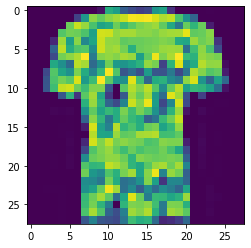

In [68]:
image, label = test_dataset[400]

plt.imshow(transforms.ToPILImage()(image))
print(label)
print(torch.argmax(model(image.view(-1, 28*28))).item())